# Games trend prediction for 2017

#### Analysis of game trends for the online store 'Ice', designed to optimize marketing strategies for year 2017.  
- This study will look at games sales accross platforms and markets in order to estimate uppcoming trends, using the available data on game names, platforms, year-of-release, sales accross different markets, user and critic scores and ERSB ratings.

## General data overview

In [1]:
import numpy as np 
from scipy import stats as st
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
try:
    games= pd.read_csv('games.csv')
except:
    games= pd.read_csv('/datasets/games.csv')

In [2]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


- changing column names to lower case for convinience:

In [3]:
games.columns= games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- checking for complete duplicates:

In [5]:
games.duplicated().sum()

0

- the 'user_score' has an anomaly: the data type is 'object' which implies that there are some string values present. let's take a closer look by applying the unique() method:

In [6]:
games.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

- as can be seen, there is a 'tbd' (to be ditermened) value in the 'user_score' column which causes the dtype to be 'object'. let's assess how many:

In [7]:
print('the number of games which have "tbd" as their user score:', len(games.query('user_score=="tbd"')))

the number of games which have "tbd" as their user score: 2424


- seeing as there is a substantial amount of games with 'tbd' as their user score, we caanot eliminate those rows.  
- missing values: columns 'name' and 'genre' have only 2 missing values each so these rows can be deleted. 
column 'year_of_release' has 269 missing values which make up only 1.6% of the data. these rows can be deleted as well.  

In [8]:
mis_values = games.isnull().sum().to_frame('missing_values')
mis_values['%'] = round(games.isnull().sum()/len(games),3)
mis_values.sort_values(by='%', ascending=False)

,missing_values,%
critic_score,8578,0.513
rating,6766,0.405
user_score,6701,0.401
year_of_release,269,0.016
name,2,0.000
platform,0,0.000
genre,2,0.000
na_sales,0,0.000
eu_sales,0,0.000
jp_sales,0,0.000


### Conclusions  
1) missing values: columns 'name','genre' and 'year_of_release'--> delete rows of missing values.  
- 'critic_score', 'user_score' and 'rating' all have a substanial amount of missing values so we cannot delete those rows. however this is of little relevance to the purposes of this study and therefore these values will remain as they are.  

2) data type conversion: 
  - column 'year_of_release'--> convert year to 'datetime' type and then extract the year (which will return an 'int' type).
  - columns 'rating', 'genre' and 'platform' will be converted to 'category' type to reduce memory volume.
3) case conversion: column names--> have already been converted to lower case.

## Data preparation

- deleting rows of NaN values present in columns 'name', 'genre' and 'year_of_release':

In [9]:
games.drop(games[games.name.isna() | games.genre.isna() | games.year_of_release.isna()].index, inplace=True)

- checking new length of table:

In [10]:
len(games)

16444

- converting 'rating', 'genre' and 'platform' columns into 'category' type: 

In [11]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [12]:
#games['platform']= games['platform'].astype('category')
#games['genre']= games['genre'].astype('category')
#games['rating']= games['rating'].astype('category')

- converting 'year_of release' to 'datetime' type and then extracting the year and checking everything is in optimal form:

In [13]:
games.year_of_release= pd.to_datetime(games.year_of_release, format='%Y').dt.year
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


- calculating the total sales for each game and storing in the 'total_sales' column:

In [14]:
games['total_sales']= games.apply(lambda row: row['na_sales']+row['eu_sales']+row['jp_sales']+row['other_sales'], axis=1)

In [15]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Data analysis

#### A review of game numbers over the years:

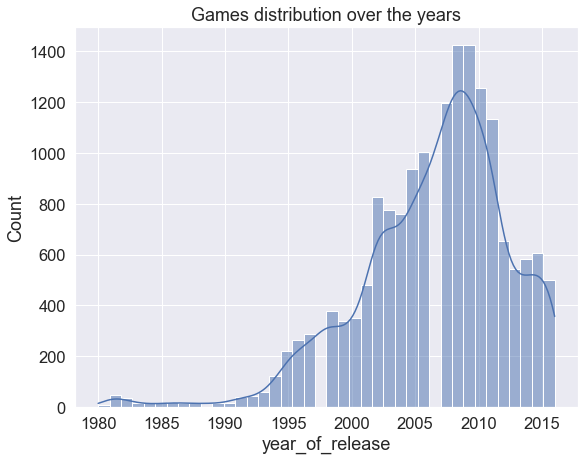

In [16]:
sns.set(rc={'figure.figsize':(9,7)}, font_scale=1.5)
sns.histplot(data=games,x='year_of_release', bins=40, kde=True).set(title='Games distribution over the years');

#### Conclusions:  
as can be seen in the distribution plot, there are 2 significant marker years which give rise to a plethora of games created and sold- the mid 90s and 2000s:  
- 1995 was a big year for the internet: Microsoft launched Windows 95, Amazon, Yahoo, eBay and Internet Explorer all launched and Java was created, enabling animation on websites.  
- early 2000s see the rise of Google and Wi-Fi wireless communication, as well as mobile internet devices...
BIG years for the internet.., which undoubtedly contributed to the rise and flurish of game creation and sales world wide, as indicated in the plot.

#### Examination of sales variation accross platforms: 

In [17]:
platform_sales= games.pivot_table(index='platform', values='total_sales', aggfunc='sum').reset_index()
platform_sales.columns= ['platform', 'sales_per_platform']
platform_sales= platform_sales.sort_values(by='sales_per_platform', ascending=False).reset_index(drop=True)
platform_sales.head()

,platform,sales_per_platform
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78


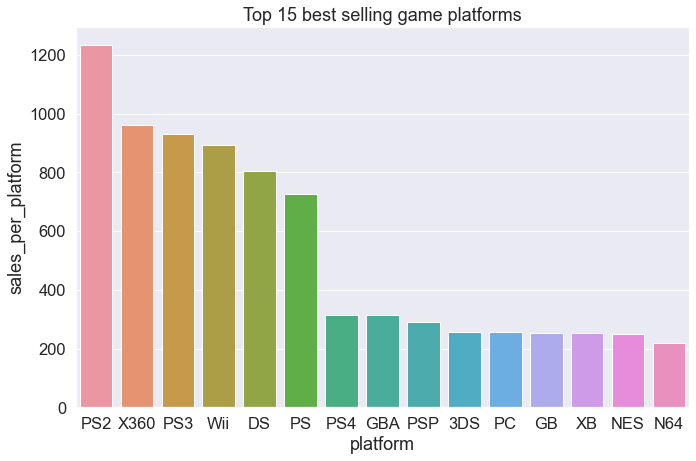

In [18]:
sns.set(rc={'figure.figsize':(11,7)}, font_scale=1.5)
sns.barplot(data=platform_sales.head(15), x='platform', y='sales_per_platform').set_title('Top 15 best selling game platforms');

- we can see a marked difference between the top 6 platforms and the rest. lets examine these 6 platforms:

In [19]:
popular_platforms= games.query('platform=="PS2" | platform=="X360" | platform=="PS3" | platform=="Wii" | platform=="DS" | platform=="PS"')
popular_platforms

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16700,Mezase!! Tsuri Master DS,DS,2009,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,tbd,E,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


[Text(0.5, 1.0, 'Top 6 most popular game platforms over the years')]

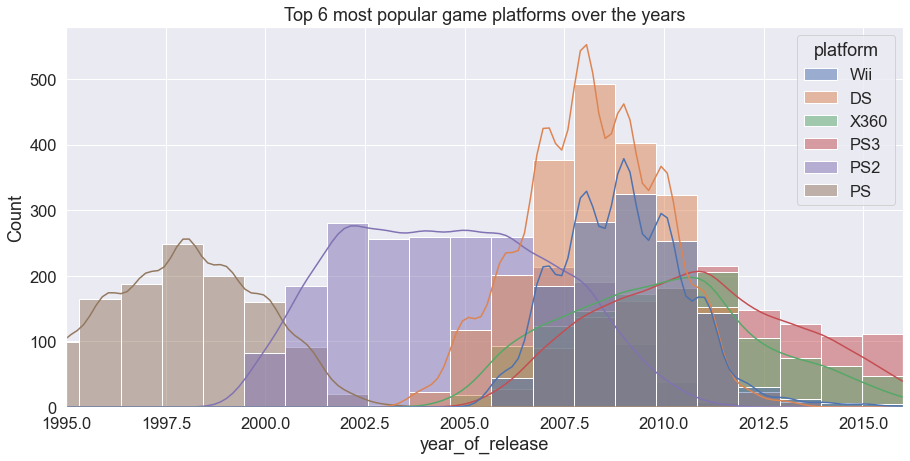

In [20]:
sns.set(rc={'figure.figsize':(15,7)}, font_scale=1.5)
plt.xlim((1995,2016))
sns.histplot(data=popular_platforms, x='year_of_release', bins=30, hue='platform', kde=True).set(title='Top 6 most popular game platforms over the years')

- a general trend can be seen from this plot: platforms are either 'off-phase' of each other (meaning one rises as the other deminishes), or they are in-sync (meaning they both rise and deminish simillarly). what this means is that one platfrom's rise in popularity could actually be the cause of the loss of interset in another platform, while at the same time competing back to back with a third platform.  
- platforms that used to be popular and now have zero sales are actually all of those that were once the most popular, as can clearly be seen from the plot: each platform's distribution is peaking and then approaching zero, in cycles of around 10 years.  
- the dissapearance of one platform and the appearance of another is around every 5 years.  

#### Conclussion:  
as can be seen from the top 6 best selling platforms, there is a consecutive rise and fall of new generation platforms. for example: PS3 is the successor of PS2, which in turn was the successor of PS and each one's sales growth was at the expense of its predeccessor. if we apply the same logic to newer version platforms of the top platforms, we may successfuly predict the upcoming best sellers for 2017!

#### Fine tunning the dataset:  
- in light of the conclusions made thus far and in view of our main purpose of predicting 2017 gaming trends, we can see that the platforms that were released prior to 1995 are essentialy obsolete and no longer rellevant to this day and age. let's update the games table to include games released from 1995 and onwards:

In [21]:
modern_games= games.loc[games.year_of_release>=1995]
modern_games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
4254,Mega Man Star Force 3: Black Ace / Red Joker,DS,2008,Action,0.22,0.00,0.22,0.02,NaN,NaN,NaN,0.46
5618,Karaoke Revolution Presents American Idol Enco...,Wii,2008,Misc,0.30,0.00,0.00,0.02,NaN,tbd,E10+,0.32
7538,Langrisser III,SAT,1996,Strategy,0.00,0.00,0.20,0.00,NaN,NaN,NaN,0.20
9553,Yu-Gi-Oh! Nightmare Troubadour (JP sales),DS,2005,Action,0.00,0.03,0.10,0.00,NaN,NaN,NaN,0.13
9523,Dreamworks 2-in-1 Party Pack,DS,2010,Misc,0.12,0.00,0.00,0.01,NaN,tbd,E,0.13


- looking at the leading sales platforms of the modern_games and their fist year of appearence:

In [22]:
top_platforms= modern_games.pivot_table(index='platform', values=['year_of_release','total_sales'], aggfunc={'year_of_release':'first', 'total_sales':'sum'}).reset_index().sort_values(by='total_sales', ascending=False)
top_platforms= top_platforms.head(6)
top_platforms

,platform,total_sales,year_of_release
12,PS2,1233.56,2004
23,X360,961.24,2010
13,PS3,931.34,2013
21,Wii,891.18,2006
3,DS,802.76,2006
11,PS,721.55,1997


- we want to find the newest sony play station, X-box and Nintendo consoles by looking at the first year of appearence of each platform, focusing on the most recent:

In [23]:
recent_platforms= modern_games.pivot_table(index='platform', values='year_of_release', aggfunc=['min']).reset_index()
recent_platforms.columns= ['platform', 'first_year_of_release']
recent_platforms.sort_values(by='first_year_of_release', ascending=False, inplace=True)
recent_platforms=recent_platforms.head(5)
recent_platforms

,platform,first_year_of_release
25,XOne,2013
14,PS4,2013
22,WiiU,2012
1,3DS,2011
16,PSV,2011


### Conclusion: 
By applying the pattern of newest model console being the ones to rise, the upcomming trends for 2017 are XOne (2013 release of Xbox consule), PS4 (2013 release of Sony play station consule) and WiiU (2012 release of Wii) and advertising resources should focous on these platforms.

- examination of global sales across platforms:

Text(0.5, 1.0, 'Total sales distribution per platform')

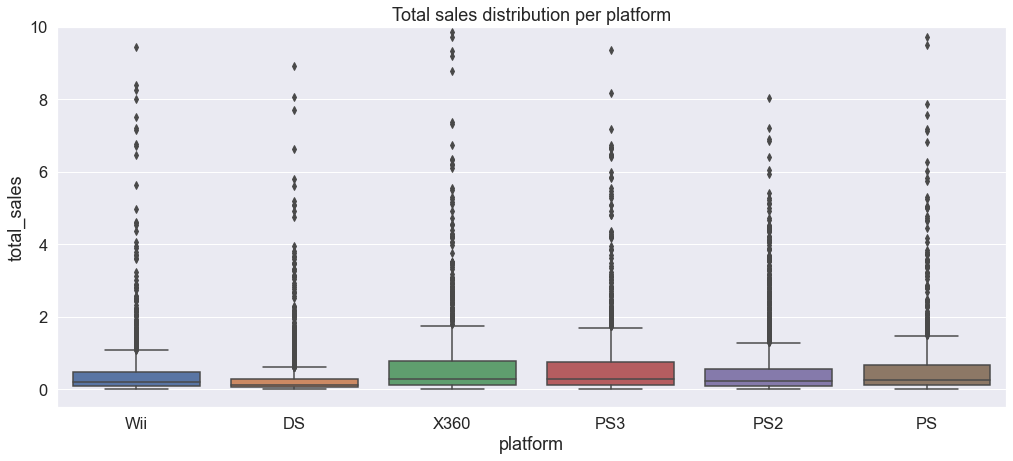

In [24]:
sns.set(rc={'figure.figsize':(17,7)}, font_scale=1.5)
plt.ylim((-0.5,10))
sns.boxplot(x= popular_platforms.platform, y= popular_platforms.total_sales).set_title('Total sales distribution per platform')


- from the plot we can see that the variance in sales numbers within each platform is fairly equivalent across platforms, i.e. the IQR apears to be even across platforms. what sets them apart are their different mean values which are influenced by the variation in outliers: the number of outliers decreases from the left part of the plot, to the right.


#### examination of professional reviews affect over sales- taking a look at the best seller PS2:  
- calculating the correlation coeficient between critic review and sales.  
- plotting a scatter plot of the 2 parameters.

the correlation between critic review score and total sales: 0.393


Text(0.5, 1.0, 'total sales Vs critic score')

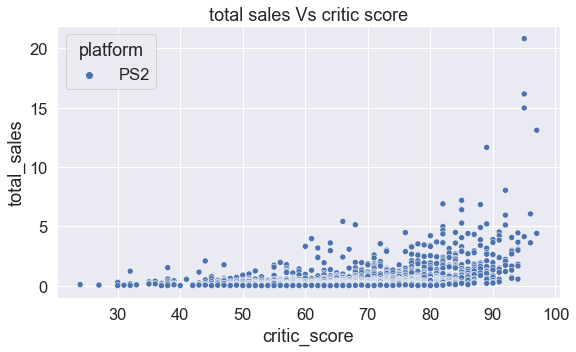

In [25]:
ps_2=modern_games.query('platform=="PS2"')
print('the correlation between critic review score and total sales:', round(ps_2.critic_score.corr(ps_2.total_sales), 3))
sns.set(rc={'figure.figsize':(9,5)}, font_scale=1.5)
sns.scatterplot(x=ps_2.critic_score, y=ps_2.total_sales, hue=ps_2.platform).set_title('total sales Vs critic score')

- the correlation between critics review score and PS2 platform total sales is 0.392536, which indicates a possitive correlation as also seen in the scaterplot above, meaning that the higher the critic review score is, the higher the sales are to a certain extent. 

- let's take a look at the other top platforms indicated in the 'popular_platforms' table, for review-sales correlation, through correlation coeficient and scatter plotting using the plot_scatter() function: 

In [52]:
def plot_scatter(row):
    sns.set(rc={'figure.figsize':(9,5)}, font_scale=1.5)
    sns.scatterplot(x=row.critic_score, y=row.total_sales, hue=row.platform).set_title('total sales Vs critic score')
    print('the correlation between critic review score and total sales: ', round(row.critic_score.corr(row.total_sales),3))
    plt.show()
    print()




the correlation between critic review score and total sales:  0.238


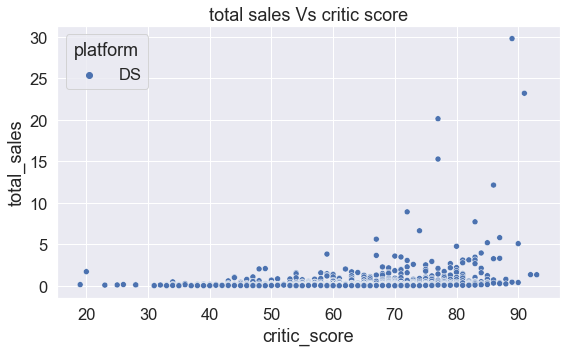


the correlation between critic review score and total sales:  0.447


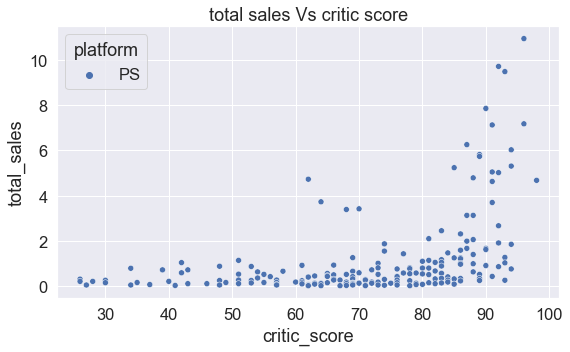


the correlation between critic review score and total sales:  0.393


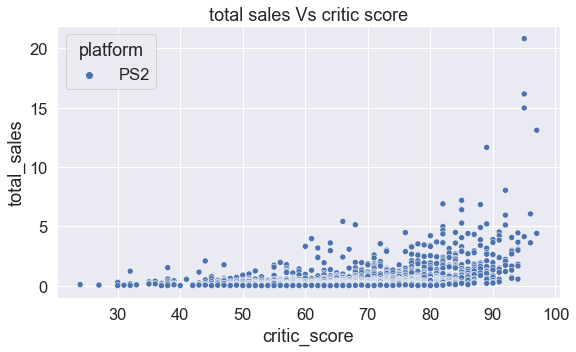


the correlation between critic review score and total sales:  0.433


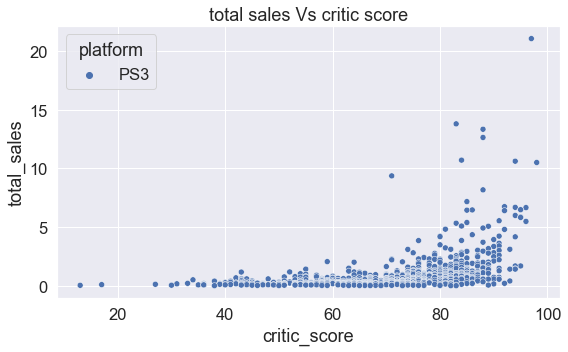


the correlation between critic review score and total sales:  0.178


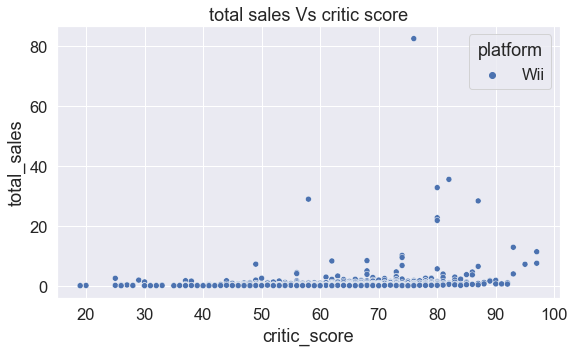


the correlation between critic review score and total sales:  0.393


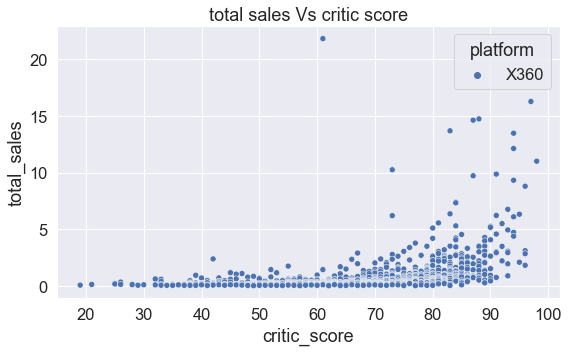

""


In [53]:
popular_platforms.groupby('platform').apply(plot_scatter)

#### Conclusion:  
as can be seen, the correlation between critic review score and total sales, differ across platforms: the highest correlation was observed in the PS platform, whereas the lowest one was observed in the Wii platform. 
these differences could be symptomatic of differences in advertising efforts and strategies applied accross the diferent platforms: maybe when there's not enough advertising effort, the weight of the critic's review becomes more enhanced and vise-versa, maybe it takes a substantial advertizing effort to counter-balance a very low critical review. 

- let's further explore  our popular platforms and see what are the top genres:

In [28]:
genre_sales= popular_platforms.pivot_table(index='genre', values= 'total_sales', aggfunc=['count', 'sum']).reset_index()
genre_sales.columns= ['genre', 'number of games', 'total_sales']
genre_sales= genre_sales.sort_values(by='total_sales', ascending=False).reset_index(drop=True)
genre_sales.head()


,genre,number of games,total_sales
0,Action,1751,1150.64
1,Sports,1436,969.76
2,Shooter,709,648.99
3,Misc,1198,625.62
4,Racing,704,490.77


Text(0.5, 1.0, 'Total sales distribution per genre')

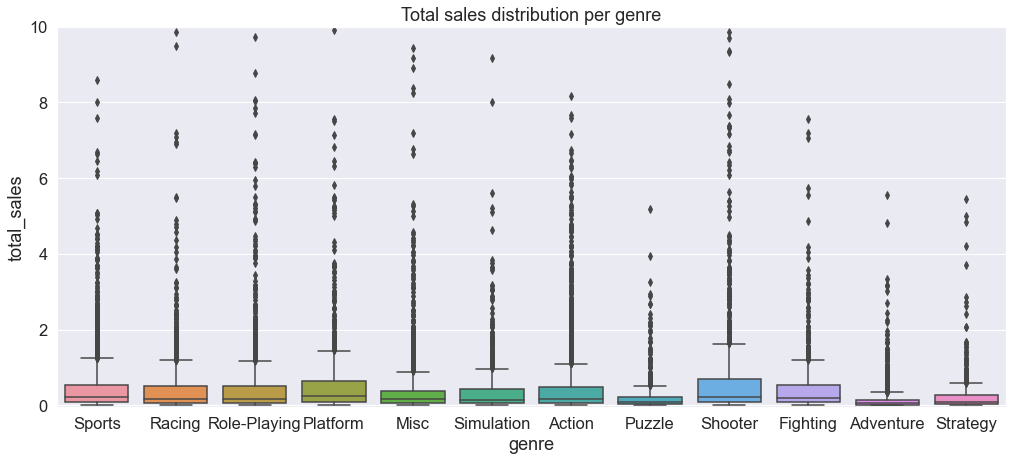

In [29]:
sns.set(rc={'figure.figsize':(17,7)}, font_scale=1.5)
plt.ylim((-0.05,10))
sns.boxplot(x= modern_games.genre, y= modern_games.total_sales).set_title('Total sales distribution per genre')

conclusion:  
genre variance is fairly evenly distributed across genres, with Puzzle and Adventure having a narrower distribution and Platform and Shooter having a wider distribution. the leading genre, which is Action, has a high density of outliers, which explain it's leading rank.

### Conclusion for Data Analysis so far:  
the advertizing efforts in year 2017 should focus on XOne, WiiU and PS4 platforms, with a strong emphasis on the Action and Sports genres whithin these platforms. 

## Regional user profile

#### Determining the top 5 platforms for each market: North America (NA), Europe (EU) and Japan (JP):

- Japan's top 5 platforms:

In [30]:
jp_top_platforms= modern_games.pivot_table(index='platform', values=['jp_sales', 'total_sales'], aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False).reset_index(drop=True)
jp_top_platforms['jp_market_share']= jp_top_platforms.apply(lambda row: round((row[1]/row[2])*100,1), axis=1)
jp_top_platforms= jp_top_platforms.head()
jp_top_platforms

,platform,jp_sales,total_sales,jp_market_share
0,DS,175.00,802.76,21.8
1,PS2,137.54,1233.56,11.1
2,PS,137.11,721.55,19.0
3,3DS,100.62,257.81,39.0
4,PS3,79.41,931.34,8.5


- North America's top 5 platforms:

In [31]:
na_top_platforms= modern_games.pivot_table(index='platform', values=['na_sales', 'total_sales'], aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False).reset_index(drop=True)
na_top_platforms['na_market_share']= na_top_platforms.apply(lambda row: round((row[1]/row[2])*100,1), axis=1)
na_top_platforms= na_top_platforms.head()
na_top_platforms

,platform,na_sales,total_sales,na_market_share
0,X360,595.74,961.24,62.0
1,PS2,572.92,1233.56,46.4
2,Wii,486.87,891.18,54.6
3,PS3,390.13,931.34,41.9
4,DS,380.31,802.76,47.4


- Europe's top 5 platforms:

In [32]:
eu_top_platforms= modern_games.pivot_table(index='platform', values=['eu_sales','total_sales'], aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False).reset_index(drop=True)
eu_top_platforms['eu_market_share']= eu_top_platforms.apply(lambda row: round((row[1]/row[2])*100,1), axis=1)
eu_top_platforms= eu_top_platforms.head()
eu_top_platforms


,platform,eu_sales,total_sales,eu_market_share
0,PS2,332.63,1233.56,27.0
1,PS3,327.21,931.34,35.1
2,X360,268.32,961.24,27.9
3,Wii,258.32,891.18,29.0
4,PS,211.19,721.55,29.3


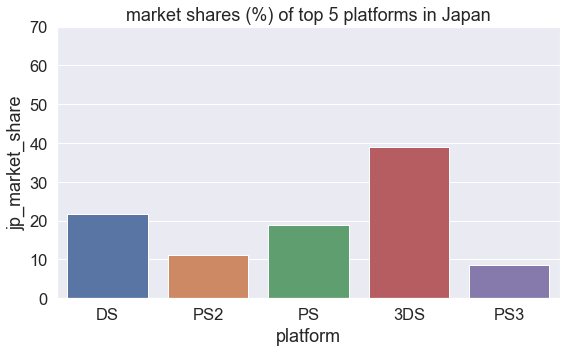

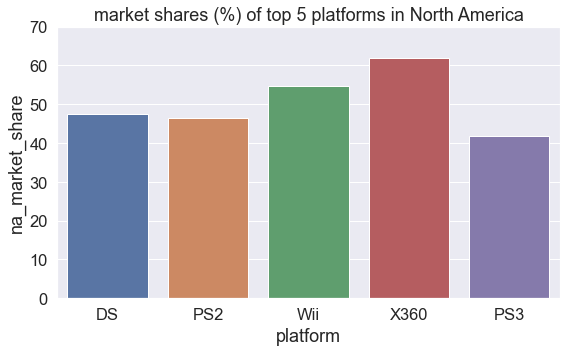

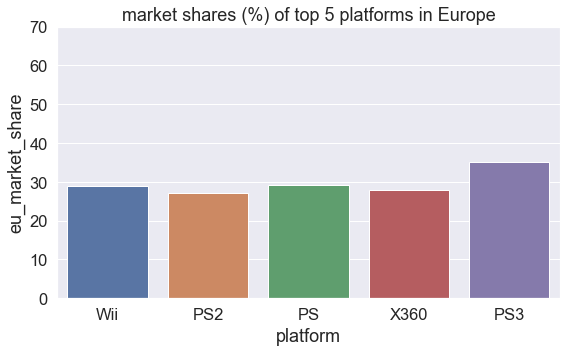

In [33]:
sns.set(rc={'figure.figsize':(9,5)}, font_scale=1.5)
plt.ylim((0,70))
sns.barplot(data=jp_top_platforms, x='platform', y='jp_market_share', order=['DS', 'PS2', 'PS', '3DS', 'PS3']).set_title('market shares (%) of top 5 platforms in Japan')
plt.show()
plt.ylim((0,70))
sns.barplot(data=na_top_platforms, x='platform', y='na_market_share', order=['DS', 'PS2', 'Wii', 'X360', 'PS3']).set_title('market shares (%) of top 5 platforms in North America')
plt.show()
plt.ylim((0,70))
sns.barplot(data=eu_top_platforms, x='platform', y='eu_market_share', order=['Wii', 'PS2', 'PS', 'X360', 'PS3']).set_title('market shares (%) of top 5 platforms in Europe')
plt.show()

- calculating the average market share across the top 5 platforms for each market: 

In [34]:
print('the average market share for japan:', round(np.mean(jp_top_platforms.jp_market_share),1))
print('the average market share for north america:', round(np.mean(na_top_platforms.na_market_share),1))
print('the average market share for europe:', round(np.mean(eu_top_platforms.eu_market_share),1))

the average market share for japan: 19.9
the average market share for north america: 50.5
the average market share for europe: 29.7


#### Conclusions:  
- as can be seen, the identity of the top 5 platforms has some variations across markets, with PS2 and PS3 being the only ones in common to all 3 markets.  
- north america has the biggets cross-platform shares which is in correlation with the population differences (data for 2016)  
- japan has the largest cross platform variance compared with the other 2 markets.  
- the 3DS was only present in the top 5 of japan, whereas Wii and X360 were only present in europe and north america.  
- it is interesting to note that while japan's population is about 1/4 of the european population (2016), japan's average market share is about 2/3 of europe's!

#### Determining the top 5 genres for each market: North America (NA), Europe (EU) and Japan (JP):

- japan's top 5 genres:

In [35]:
jp_top_genres= modern_games.pivot_table(index='genre', values=['jp_sales', 'total_sales'], aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False).reset_index(drop=True)
jp_top_genres['jp_market_share']= jp_top_genres.apply(lambda row: round((row[1]/row[2])*100,1), axis=1)
jp_top_genres= jp_top_genres.head()
jp_top_genres

,genre,jp_sales,total_sales,jp_market_share
0,Role-Playing,315.17,888.47,35.5
1,Action,146.46,1645.07,8.9
2,Sports,104.31,1258.33,8.3
3,Misc,99.51,773.67,12.9
4,Platform,77.05,611.83,12.6


- North America's top 5 genres:

In [36]:
na_top_genres= modern_games.pivot_table(index='genre', values=['na_sales', 'total_sales'], aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False).reset_index(drop=True)
na_top_genres['na_market_share']= na_top_genres.apply(lambda row: round((row[1]/row[2])*100,1), axis=1)
na_top_genres= na_top_genres.head()
na_top_genres

,genre,na_sales,total_sales,na_market_share
0,Action,814.11,1645.07,49.5
1,Sports,655.07,1258.33,52.1
2,Shooter,527.59,967.94,54.5
3,Misc,392.43,773.67,50.7
4,Racing,342.82,692.41,49.5


- Europe's top 5 genres:

In [37]:
eu_top_genres= modern_games.pivot_table(index='genre', values=['eu_sales','total_sales'], aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False).reset_index(drop=True)
eu_top_genres['eu_market_share']= eu_top_genres.apply(lambda row: round((row[1]/row[2])*100,1), axis=1)
eu_top_genres= eu_top_genres.head()
eu_top_genres

,genre,eu_sales,total_sales,eu_market_share
0,Action,503.35,1645.07,30.6
1,Sports,367.35,1258.33,29.2
2,Shooter,308.23,967.94,31.8
3,Racing,230.32,692.41,33.3
4,Misc,208.88,773.67,27.0


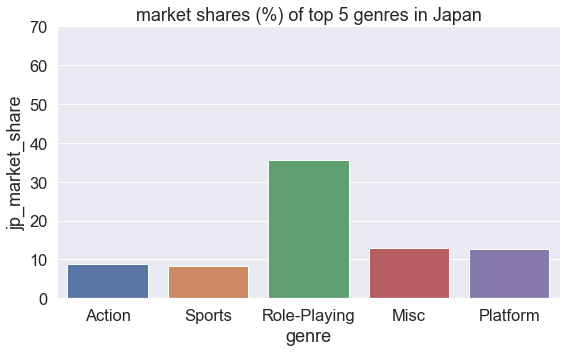

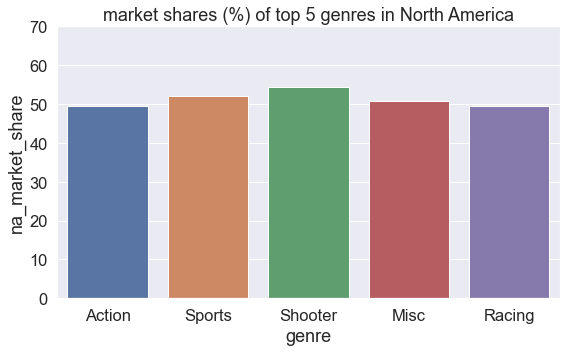

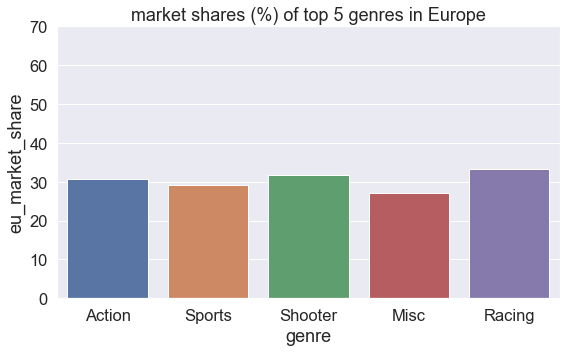

In [38]:
sns.set(rc={'figure.figsize':(9,5)}, font_scale=1.5)
plt.ylim((0,70))
sns.barplot(data=jp_top_genres, x='genre', y='jp_market_share', order=['Action', 'Sports', 'Role-Playing', 'Misc', 'Platform']).set_title('market shares (%) of top 5 genres in Japan')
plt.show()
plt.ylim((0,70))
sns.barplot(data=na_top_genres, x='genre', y='na_market_share', order=['Action', 'Sports', 'Shooter', 'Misc', 'Racing']).set_title('market shares (%) of top 5 genres in North America')
plt.show()
plt.ylim((0,70))
sns.barplot(data=eu_top_genres, x='genre', y='eu_market_share', order=['Action', 'Sports', 'Shooter', 'Misc', 'Racing']).set_title('market shares (%) of top 5 genres in Europe')
plt.show()

calculation the variance in market share across the top 5 genres for each market:

In [39]:
print('the market share variance for japan:', round(np.var(jp_top_genres.jp_market_share),1))
print('the market share variance for north america:', round(np.var(na_top_genres.na_market_share),1))
print('the market share variance for europe:', round(np.var(eu_top_genres.eu_market_share),1))

the market share variance for japan: 102.1
the market share variance for north america: 3.5
the market share variance for europe: 4.7


#### Conclusions:  
- it is noticable from these ploats as well that the biggest market in numbers is that of north america, which is in correlation to it's largest population.  
- the largest variance is that in the japanese market by a factor of more than 20!  
- the most prominant genre in the japanese market- Role-Playing- is completely abscent in the other 2 markets.  
- the highest european market share genre- Racing, is completely abscent in the japanese market. 
- these differences could possibly be contributed to caltural variations. for example: 
    - japan's leading genre of Role-Playing could be a means of self expression in a more conservative society such as that found in japan.  
    - europe's racing culture could be reflected in the fact the this genre has the highest market share within this market. 
    - and the americans have the right to bear arms.., which may contribute to the fact that the Shooter genre, is the largest market share in north america.   

- examining the affect of ESRB ratings on sales in different regions:

In [40]:
print('the correlation between ESRB ratings and japan sales:', round(modern_games.critic_score.corr(modern_games.jp_sales),3))
print('the correlation between ESRB ratings and north america sales:', round(modern_games.critic_score.corr(modern_games.na_sales),3))
print('the correlation between ESRB ratings and europe sales:', round(modern_games.critic_score.corr(modern_games.eu_sales),3))


the correlation between ESRB ratings and japan sales: 0.154
the correlation between ESRB ratings and north america sales: 0.24
the correlation between ESRB ratings and europe sales: 0.221


conclusions:  
- in all 3 regions there appears to be a possitive correlation between ESRB ratings and sales.  
- this correlation is more simillar between north america and europe (about 0.2) while the correlation in the japanese market is lower (about 1.5).  
- these differences could be due to any number of reasons: perhaps the japanese market is more affected by advertising than by rating, compared with the other 2 markets. however, in all 3 regions, the correlation is not substantial in magnitude.

## Hypothesis testing

### 1) Average user ratings of the Xbox One and PC platforms are the same

- null hypothesis (H0): there is no difference between the mean values of user ratings for Xbox-One and PC platforms.  
- alternative hypothesis (H1): there IS a difference between the mean values of user ratings for Xbox-One and PC platforms.

in order to calculate the mean values for the user score we need to eliminate the missing values as well as those to-be-determined ('tbd'):

In [41]:
user_score_games= modern_games.drop(modern_games[modern_games.user_score.isna()].index)
user_score_games.drop(user_score_games[user_score_games.user_score=='tbd'].index, inplace=True)
user_score_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7459 entries, 0 to 16705
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             7459 non-null   object 
 1   platform         7459 non-null   object 
 2   year_of_release  7459 non-null   int64  
 3   genre            7459 non-null   object 
 4   na_sales         7459 non-null   float64
 5   eu_sales         7459 non-null   float64
 6   jp_sales         7459 non-null   float64
 7   other_sales      7459 non-null   float64
 8   critic_score     6890 non-null   float64
 9   user_score       7459 non-null   object 
 10  rating           7376 non-null   object 
 11  total_sales      7459 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 757.6+ KB


In [42]:
user_score_games.user_score= round(user_score_games.user_score.astype('float'),1)

In [43]:
user_score_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [44]:
print('the average user rating score for X-box One platform:', round(user_score_games.query('platform=="XOne"').user_score.mean(),1))
print('the sample size for X-box One platform:', len(user_score_games.query('platform=="XOne"')))
print('the variance for X-box One platform sample:', round(user_score_games.query('platform=="XOne"').user_score.var(),1))
print('the average user rating score for PC platform:', round(user_score_games.query('platform=="PC"').user_score.mean(),1))
print('the sample size for PC platform:', len(user_score_games.query('platform=="PC"')))
print('the variance for PC platform sample:', round(user_score_games.query('platform=="PC"').user_score.var(),1))

the average user rating score for X-box One platform: 6.5
the sample size for X-box One platform: 182
the variance for X-box One platform sample: 1.9
the average user rating score for PC platform: 7.1
the sample size for PC platform: 752
the variance for PC platform sample: 2.3


- the standard alpha value of 0.05 will be used, since there is no need for a more rigurous confidence level.  
- since the variance of the 2 samples are roughly the same, we can use the t-test.  
- the 2 samples are indipendant

In [45]:
alpha=0.05
xone_user_scores= user_score_games.query('platform=="XOne"').user_score
pc_user_scores= user_score_games.query('platform=="PC"').user_score 

In [46]:
results= st.ttest_ind(xone_user_scores, pc_user_scores)
print('p-value: ', results.pvalue)

p-value:  9.379956219356061e-06


In [47]:
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

We reject the null hypothesis


#### Conclusion: there IS a difference between the average user ratings for X-box One and PC platforms.

### 2) Average user ratings for the Action and Sports genres are different.

- null hypothesis (H0): there is no difference between the mean values of user ratings for Action and Sports genres.  
- alternative hypothesis (H1): there IS a difference between the mean values of user ratings for Action and Sports genres.

In [48]:
print('the average user rating score for Action genre:', round(user_score_games.query('genre=="Action"').user_score.mean(),1))
print('the sample size for Action genre:', len(user_score_games.query('genre=="Action"')))
print('the variance for Action genre sample:', round(user_score_games.query('genre=="Action"').user_score.var(),1))
print('the average user rating score for Sports genre:', round(user_score_games.query('genre=="Sports"').user_score.mean(),1))
print('the sample size for Sports genre:', len(user_score_games.query('genre=="Sports"')))
print('the variance for Sports genre sample:', round(user_score_games.query('genre=="Sports"').user_score.var(),1))

the average user rating score for Action genre: 7.1
the sample size for Action genre: 1796
the variance for Action genre sample: 2.0
the average user rating score for Sports genre: 7.0
the sample size for Sports genre: 1081
the variance for Sports genre sample: 2.6


- here too, the standard alpha value of 0.05 will be used, since there is no need for a more rigurous confidence level.  
- since the variance of the 2 samples are roughly the same, we can use the t-test.  
- the 2 samples are indipendant

In [ ]:
alpha=0.05
action_user_scores= user_score_games.query('genre=="Action"').user_score
sports_user_scores= user_score_games.query('genre=="Sports"').user_score 

In [ ]:
results= st.ttest_ind(action_user_scores, sports_user_scores)
print('p-value: ', results.pvalue)

In [ ]:
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

#### Conclusion: there is NO difference between the average user ratings for the Action genre and the Sports genre.

## Overall conclusions:  
- Globaly, the upcoming trends for 2017 are the XOne, WiiU and PS4 platforms, with leading genres being the Action and Sports genres whithin these platforms.  
- when considering market-speciffic advertising, the following advertising focuses are recommended:  
  - Japan market: the highest japanese market share is of the Wii platforms, which is of the japanese 'Nintendo' corporation. it is therefore advisable to focous advertising on the uppcomming WiiU platform, (also by 'nintendo') with an emphasis on the role-playing genre, which has the highest market share in this region.  
  - North America market: the most dominant platform in this region is the X360 by the american 'microsoft' corporation. it is therefore advisable to focous advertising on the upcoming XOne platform (also by 'microsoft') with an emphasis on the shooter and sports genres, which have the highest market share in this region.  
  - Europe market: the most dominant platform in this region is the PS3 by the japanese 'sony' corporation. it is therefore advisable to focous advertising on the upcoming PS4 platform (also by 'sony') with an emphasis on the racing and shooter genres, which have the highest market share in this region.  